# Persistent topological spectra

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [1]:
import numpy as np
import qtda_modules.qtda_module as qtda
from qiskit.visualization import plot_histogram

In this notebook we explain the persistent topological analysis, in particular how topological spectra can be obtained on different scales from a data filtration and how to extract Betti-numbers from them. For this the data cloud is described via a filtration of simplicial complexes, encoding topological and geometric features of the data on different filtration scales.

## Quantum circuit for the topological analysis

As an example, the quantum circuit for the topological analysis of an example simplicial complex of four abstract points is draw. The complex is shown below. To detect to 1-dimensional hole in the simplex $[1,1,1,0]$, we have to find the dimension of the 0-Eigenspace of the combinatorial Laplacian $\Delta_k$ on first order $k=1$.

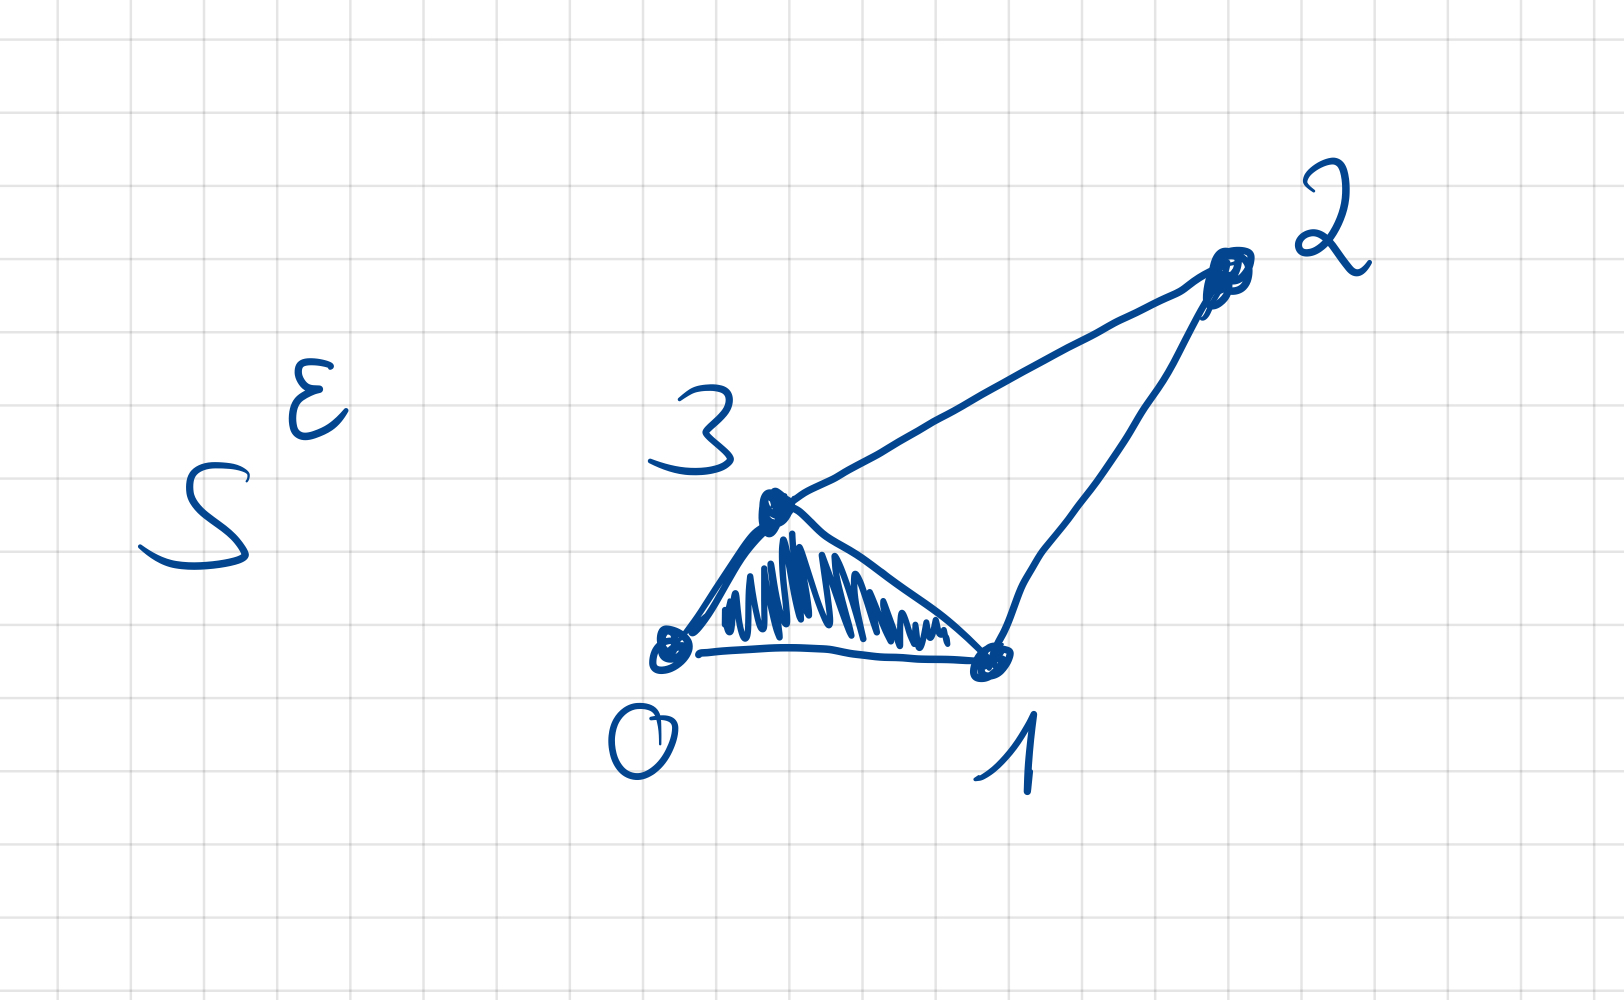

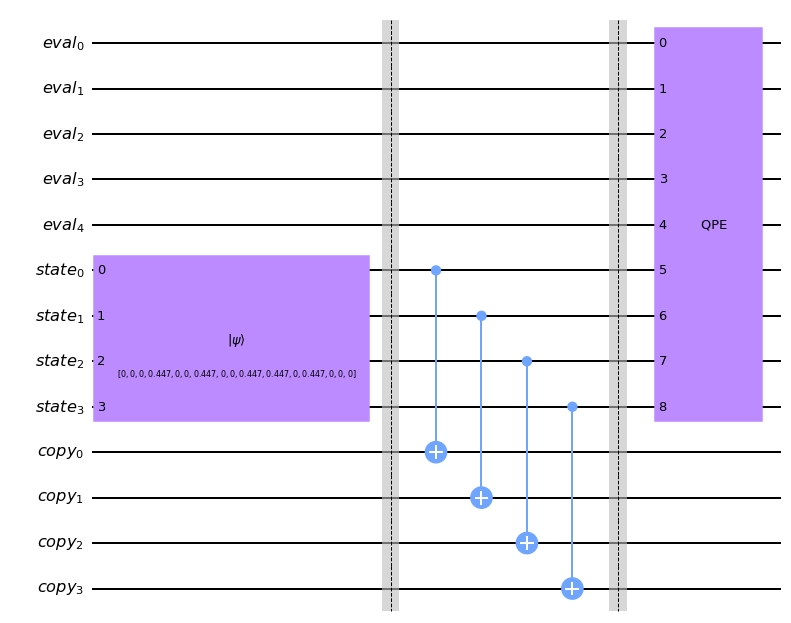

In [2]:
n_vertices = 4
num_eval_qubits = 5

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
S2 = [(1,0,1,1)]
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}
k = 1 # order of the combinatorial Laplacian
qc = qtda.QTDA_algorithm(num_eval_qubits, k, state_dict)
qc.draw('mpl')

We estimate the number of 1-holes from the output counting statics, by adding measurements on the evaluation qubits (listed in qc.eval_qubits). The number of 1-holes is the probability of measuring eigenvalue $0$ of $\Delta_1$ times the dimension of the 1-simplex subspace
$$
\dim \ker \Delta_1 = P(\text{EV 0}) * \dim S_1
$$

In [22]:
qc.add_register(ClassicalRegister(num_eval_qubits))
for q in qc.eval_qubits:
    qc.measure(q,q)

shots = 1000
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=shots)
counts = job.result().get_counts(qc)

The number of 1-holes is 1.02


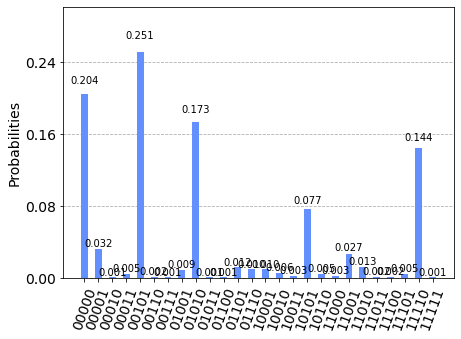

In [23]:
dim = len(state_dict[1]) # dimension of 1-simplex space
prob = counts.get("0"*num_eval_qubits)/shots # probability of eigenvalue 0

print('The number of 1-holes is', dim * prob)
plot_histogram(counts)

### Topological spectra

To obtain the full topological spectra, i.e. all eigenvalues of $\Delta_k$ on all order $k=1,2,3$ with the dimension of the corresponding eigenspaces, we just call `qtda.Q_top_spectra` and extract the topological spectra. Note that to obtain reliable estimates for all eigenvalues, a larger numerical precision (num_eval_qubits) of the phase estimation algorithm is necessary.

In [9]:
shots = 500
num_eval_qubits = 10

data = qtda.Q_top_spectra(state_dict, num_eval_qubits, shots)
spectra = data.get_spectra()

Topological order:  0
Topological order:  1
Topological order:  2
Topological order:  3
calculation terminated because no simplex of size ...



Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.419916921826742: 1.008, 1.209958460913371: 2.896}


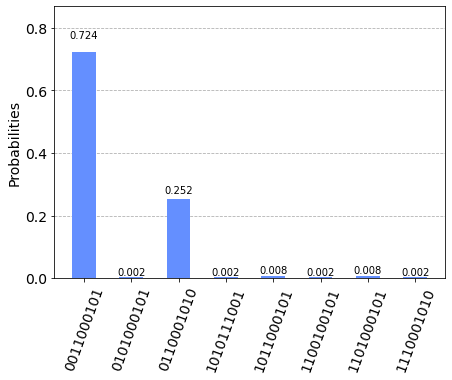


Topological order:  1
Number of holes:  0.99
Dimension of the k-simplex subspace:  5
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0.99, 1.209958460913371: 1.71, 2.419916921826742: 0.99, 3.722004199560928: 1.18}


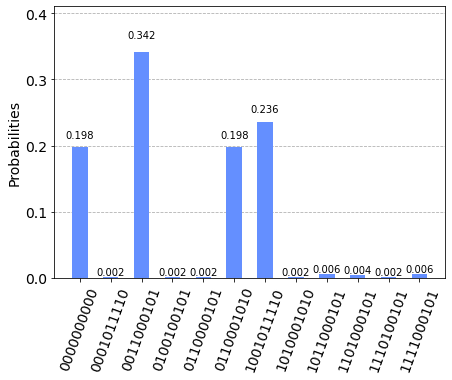


Topological order:  2
Number of holes:  0
Dimension of the k-simplex subspace:  1
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 3.722004199560928: 0.97}


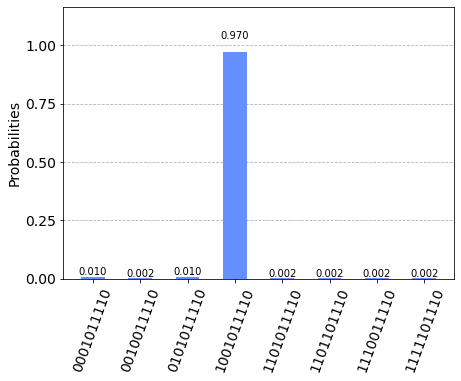

In [10]:
for top_order in spectra.keys():
    print()
    print('Topological order: ', top_order)
    print('Number of holes: ', spectra[top_order][0.0])
    print('Dimension of the k-simplex subspace: ', len(data.state_dict[top_order]))
    print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
    print(spectra[top_order])
    display(plot_histogram(data.get_counts()[top_order]))

Only eigenvalues are considered with at least 2% probability, all others are considered as noise. The chop-value (minimum number of counts) can be set in the `get_spectra(chop=..)` method. We see that the dimensions of the eigenspaces sum up approximately to the dimension of the k-simplex space, as expected.

## Persistent topological spectra of data filtration

In the next step, we want to analyse the topological and geometric features of a full filtration of simplicial complexes describing a point data cloud.

The precise procedure is described somewhere else???

We use the gudhi-library for TDA to generate the filtration of simplicial complexes describing point data. The data can either be provided by data points in euclidean space, or as abstract distance matrix (containing all pairwise distances of the points) in a general metric space.

We first consider a square of four points:

picture !!!

In [2]:
point_data = np.array([
    [0.,0.],
    [1.,0.],
    [1.,1.],
    [0.,1.],
    ])

# alternatively a distance matrix (here generated from the point data for exemplification)
# can be used
from scipy.spatial import distance_matrix
dist_mat = distance_matrix(point_data, point_data)

filtration = qtda.data_filtration(
    data=point_data, 
#     distance_matrix=dist_mat, 
    max_dimension=3, 
    max_edge_length=2
    )

A maximal dimension up to which simplices are considered and a maximal edge-length have to be given. This allows a more efficient generation of the filtration and is reasonable, since usually one is interested in topological features up to a given order.

The persistence diagram of the filtration can be plotted. From there it is seen, that on zeroth order several (four) features (connected components) appear at scale $\varepsilon = 0$, which die again at scale $\varepsilon = 1$, at which only a single connected component persist. At this filtration scale, on first order, the 1-dimensional hole in the square is born when the four vertices connect to a single square. This feature dies at $\varepsilon = \sqrt{2}$ when the diagonal vertices connect.

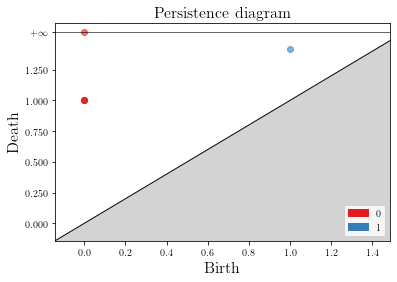

In [3]:
filtration.plot_persistence_diagram()

In [4]:
shots = 1000
num_eval_qubits = 10
# epsilons = [0.1, 1.1, 1.5]

data = qtda.Q_persistent_top_spectra(
    data = point_data,
#     distance_matrix=distance_matrix, 
    max_dimension=3, 
    max_edge_length=2, 
    num_eval_qubits=num_eval_qubits, 
    shots=shots)


Filtration scale:  0.0

Topological order:  0
21.505728006362915
43.30972909927368
Topological order:  1
calculation terminated because no simplex of dimension 1

Filtration scale:  1.0

Topological order:  0
15.654361963272095
23.896929025650024
Topological order:  1
12.705208778381348
19.38786482810974
Topological order:  2
calculation terminated because no simplex of dimension 2

Filtration scale:  1.4142135623730951

Topological order:  0
0.7752900123596191
0.07941675186157227
Topological order:  1
0.7911961078643799
0.06433486938476562
Topological order:  2
7.3794920444488525
10.518097162246704
Topological order:  3
calculation terminated because no simplex of dimension 3


Below, the topological spectra (eigenvalues of the combinatorial laplacian $\Delta_k$ with dimension of corresponding eigenspace) are shown on all filtration scales $\varepsilon = 0,1,\sqrt{2}$ and orders $k=0,1$. The dimension of the Zero-eigenspace (i.e. the kernal of $\Delta_k$) gives the number of holes at this topological order. Note that $n$ 0-dimensional holes mean $n-1$ connected components. Further, the counting statistics of the QTDA-circuit is shown.

Note that for the dimension of the Zero-eigenspace, a much lower numerical precision is sufficient. Already with only five numerical evaluation qubits (of the phase estimation algorithm), the number of holes at different scales and topological orders is estimated very well.



Filtration scale:  0.0

Topological order:  0
Number of holes:  3.064
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 3.064, 1.209958460913371: 0.912}


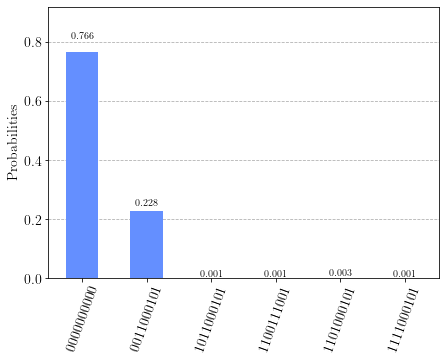



Filtration scale:  1.0

Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.419916921826742: 1.996, 1.209958460913371: 1.916}


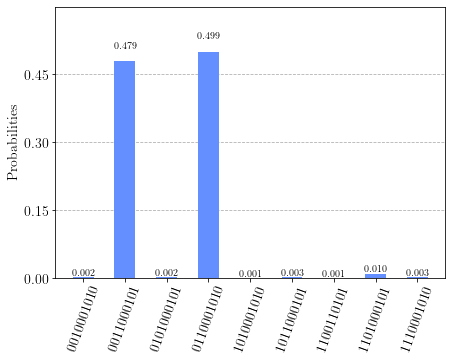


Topological order:  1
Number of holes:  1.068
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 1.068, 1.209958460913371: 0.992, 2.419916921826742: 1.892}


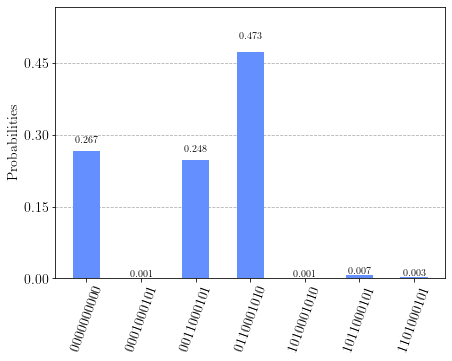



Filtration scale:  1.4142135623730951

Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 1.209958460913371: 3.836}


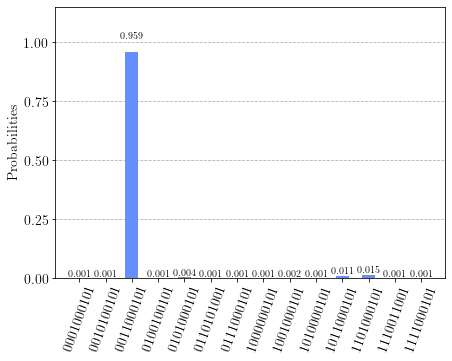


Topological order:  1
Number of holes:  0
Dimension of the k-simplex subspace:  6
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 1.209958460913371: 5.772}


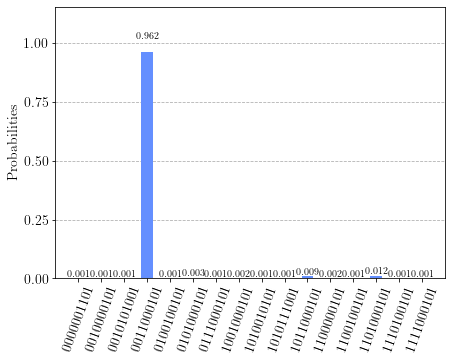


Topological order:  2
Number of holes:  1.028
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 1.028, 1.209958460913371: 2.864}


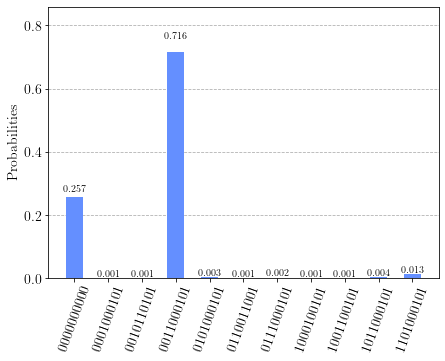

In [5]:
eigenvalue_dict = data.get_eigenvalues()

for eps in eigenvalue_dict.keys():
    print()
    print()
    print('Filtration scale: ', eps)
    for top_order in eigenvalue_dict[eps].keys():
        print()
        print('Topological order: ', top_order)
        print('Number of holes: ', eigenvalue_dict[eps][top_order][0.0])
        print('Dimension of the k-simplex subspace: ', len(data.state_dict[eps][top_order]))
        print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
        print(eigenvalue_dict[eps][top_order])
        display(plot_histogram(data.get_counts()[eps][top_order]))

We see that the 1-dimensional hole in the square is born at filtration scale $\varepsilon = 1$ and terminates at $\varepsilon = \sqrt{2}$ when the inner of the square (the 2-simplices $[0,1,1,1],[1,0,1,1],[1,1,0,1]$ and $[1,1,1,0]$) is added.

The four connected components of the four separate points (i.e. three 0-dimensional holes) die at filtration scale $\varepsilon = 1$, when the connecting edges are added to the filtration.